In this notebook, I'm going to use the Fanduel Table I scraped and cleaned in the "Import_and_Clean_FanDuel_NoStats" notebook to see what fun facts we can find about how players did compared to their fanduel price this year. While my data will come from a csv version of my cleaned data, the original data come from RotoGuru1.com

My goal is to see if there are any players who significantly out performed their average price, and if there are any common trends someone can look for to see if certain positions may be cheaper and still provide a high level of output

In [1]:
#pulling in all the necessary python libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from tabulate import tabulate
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

In [2]:
#create frame from saved csv of table I scraped and cleaned from RotoGuru1
tight_frame = pd.read_csv('tight_frame.csv')
#rename columns
tight_frame.columns = ['Row','Date','Position','Name','Fanduel_Points','Fanduel_Price','Team','Minutes_Played','Home_or_Away','Opponent']
tight_frame.dtypes

Row                 int64
Date               object
Position           object
Name               object
Fanduel_Points    float64
Fanduel_Price     float64
Team               object
Minutes_Played    float64
Home_or_Away       object
Opponent           object
dtype: object

First, I want to add a column that would calculate the expected number of points for a player to score based on their price for each player.<br>
Surprisingly, I couldn't find anything letting me know how fanduel calculates price, even though they have a "Value" section after games that lets you know how well a player did based on a multiple of their expected points. <br><br>
For example, if Gary Harris costs 5700 and scores 27.7 points, Fanduel will tell you that he scored 4.9 times his expected total. If Nikola Jokic costs 10200 and scores 71.9, FanDuel will tell you that he scored 7.0x his expected value. If monte Morris costs 4600 and scores 5.5, he is shown as having earned 1.2x his value.

In general, it seems like the equation they are using is round(price/1000,1) = expected value. <br>
For example:<br>
Gary Harris scores 27.7<br>
27.7/4.9 = 5.65<br>
5.65x1000 = 5650<br><br>
Nikola Jokic scores 71.9<br>
71.9/7 = 10.27<br>
10.27x1000 = 102700<br><br>
Monte Morris scores 5.5<br>
5.5/1.2=4.58<br>
4.58x1000 = 4583<br><br>

Online, it seems like there are alot of opinions on how to calculate value, but I'm going to use FanDuel's method since it is consistent and since they're the ones who made the game up in the first place. Then, i'm just going to find the average amount we can expect a player to exceed their value by, since it does seem like this system artificially inflates the "value" of most players.




In [3]:
#creating a column with expected points scored based on price
tight_frame['Expected_Points'] = tight_frame['Fanduel_Price'].apply(lambda x: round (x/1000,1))
#creating a column with Fanduel's value multiplier
tight_frame['Fanduel_multiple'] = (tight_frame['Fanduel_Points']/tight_frame['Expected_Points'])


Now I'm gonna take some time to look at measures of centrality for the value multiple so we can figure out a baseline for what is an expected value multiple. i am going to ignore anyone who scored 0 fanduel points, since that means they were likely hurt, did not play anyway, or played garbage time and might as well not have played. I will not ignore these when looking at specific players since that matters more, but day to day if somebody starts an injured person or benchwarmer then they shouldn't be shocked if that person scores zero.

In [4]:
#clearing an extra column
del tight_frame['Row']

In [5]:
#I am making a data frame with most of the scores
#but ignoring zeroes for now since that means someone scored zero points and most likely did not play
no_zeros = tight_frame[tight_frame['Fanduel_multiple'] != 0].reset_index()

In [6]:
#I discovered that my data cleaning had pulled information from both the 2018-2019 season and from the playoffs,
#which I do not want, so I'm pulling those out here
no_zeros['Date'] = pd.to_datetime(no_zeros['Date'])
#setting dates for Oct 22 2019 and March 10 2020 which is when the season began and then when the season shut down due to COVID
start_date = '10-22-2019'
end_date = '3-10-2020'
#creating filtered column of those dates
no_zeros['mask'] = (no_zeros['Date'] >= start_date) & (no_zeros['Date'] <= end_date)
no_zeros

index       Date Position                Name  Fanduel_Points  \
0          0 2019-01-01       SG      Beasley, Malik            40.7   
1          1 2019-01-01       SG        Hield, Buddy            40.0   
2          2 2019-01-01       PG     Lillard, Damian            39.2   
3          3 2019-01-01       PG        Simmons, Ben            38.8   
4          4 2019-01-01       SG  Bogdanovic, Bogdan            37.5   
...      ...        ...      ...                 ...             ...   
38466  61036 2020-09-15        C   Harrell, Montrezl            22.6   
38467  61037 2020-09-15        C    Williams, Robert             9.8   
38468  61038 2020-09-15        C        Zubac, Ivica             8.4   
38469  61039 2020-09-15        C       Olynyk, Kelly             7.9   
38470  61047 2020-09-15        C      Plumlee, Mason            -1.0   

       Fanduel_Price Team  Minutes_Played Home_or_Away Opponent  \
0             4500.0  den       29.933333         Home      nyk   
1             6900.0  sac       39.033333         Home      por   
2             9200.0  por       41.900000         Away      sac   
3             9800.0  phi       32.833333         Away      lac   
4             6100.0  sac       35.550000         Home      por   
...              ...  ...             ...          ...      ...   
38466         5000.0  lac       25.716667         Home      den   
38467         4000.0  bos       11.400000         Home      mia   
38468         4700.0  lac       14.300000         Home      den   
38469         4200.0  mia       10.450000         Away      bos   
38470         3700.0  den        7.866667         Away      lac   

       Expected_Points  Fanduel_multiple   mask  
0                  4.5          9.044444  False  
1                  6.9          5.797101  False  
2                  9.2          4.260870  False  
3                  9.8          3.959184  False  
4                  6.1          6.147541  False  
...                ...               ...    ...  
38466              5.0          4.520000  False  
38467              4.0          2.450000  False  
38468              4.7          1.787234  False  
38469              4.2          1.880952  False  
38470              3.7         -0.270270  False  

[38471 rows x 13 columns]

In [7]:
no_zeros

index       Date Position                Name  Fanduel_Points  \
0          0 2019-01-01       SG      Beasley, Malik            40.7   
1          1 2019-01-01       SG        Hield, Buddy            40.0   
2          2 2019-01-01       PG     Lillard, Damian            39.2   
3          3 2019-01-01       PG        Simmons, Ben            38.8   
4          4 2019-01-01       SG  Bogdanovic, Bogdan            37.5   
...      ...        ...      ...                 ...             ...   
38466  61036 2020-09-15        C   Harrell, Montrezl            22.6   
38467  61037 2020-09-15        C    Williams, Robert             9.8   
38468  61038 2020-09-15        C        Zubac, Ivica             8.4   
38469  61039 2020-09-15        C       Olynyk, Kelly             7.9   
38470  61047 2020-09-15        C      Plumlee, Mason            -1.0   

       Fanduel_Price Team  Minutes_Played Home_or_Away Opponent  \
0             4500.0  den       29.933333         Home      nyk   
1             6900.0  sac       39.033333         Home      por   
2             9200.0  por       41.900000         Away      sac   
3             9800.0  phi       32.833333         Away      lac   
4             6100.0  sac       35.550000         Home      por   
...              ...  ...             ...          ...      ...   
38466         5000.0  lac       25.716667         Home      den   
38467         4000.0  bos       11.400000         Home      mia   
38468         4700.0  lac       14.300000         Home      den   
38469         4200.0  mia       10.450000         Away      bos   
38470         3700.0  den        7.866667         Away      lac   

       Expected_Points  Fanduel_multiple   mask  
0                  4.5          9.044444  False  
1                  6.9          5.797101  False  
2                  9.2          4.260870  False  
3                  9.8          3.959184  False  
4                  6.1          6.147541  False  
...                ...               ...    ...  
38466              5.0          4.520000  False  
38467              4.0          2.450000  False  
38468              4.7          1.787234  False  
38469              4.2          1.880952  False  
38470              3.7         -0.270270  False  

[38471 rows x 13 columns]

In [8]:
#now I'm filtering for dates in this season
multiples = no_zeros[no_zeros['mask'] != False].reset_index()

In [9]:
#deleting extra columns
del multiples['index']
del multiples['level_0']
del multiples['mask']

In [10]:
#saving this frame as a csv so I can mess around with it in tableau
multiples.to_csv('multiples.csv')

In [11]:
#Taking some measures of centrality here
average_multiple = multiples.mean()
median_multiple = multiples.median()
std_multiple = multiples.std()
print('Averages for NBA Players:')
print(average_multiple)
print('Medians for NBA Players:')
print(median_multiple)
print('Standard Deviations for NBA Players')
print(std_multiple)

Averages for NBA Players:
Fanduel_Points        21.956097
Fanduel_Price       5027.090251
Minutes_Played        23.422822
Expected_Points        5.027090
Fanduel_multiple       4.227806
dtype: float64
Medians for NBA Players:
Fanduel_Points        20.000000
Fanduel_Price       4300.000000
Minutes_Played        24.133333
Expected_Points        4.300000
Fanduel_multiple       4.171429
dtype: float64
Standard Deviations for NBA Players
Fanduel_Points        14.144547
Fanduel_Price       1852.314544
Minutes_Played         9.783340
Expected_Points        1.852315
Fanduel_multiple       2.209532
dtype: float64


<ipython-input-11-20abe372250d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_multiple = multiples.mean()
<ipython-input-11-20abe372250d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  median_multiple = multiples.median()


Immediate thoughts: <br>
The average/median player scores roughly 4.2 times their value according to how fanduel does their math<br>
<br>
The mean and median for points being around 20 is higher than I expected. Typically if my players all get 20 I feel pretty good about myself. It seems like average players should earn roughly ~.93 fanduel points per minute played (21.95 avg fanduel points/23.5 avg minutes), although the medians suggest a wider gap (20/24.13 = ~.82 points per minute)

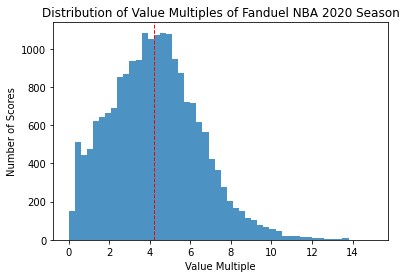

In [12]:
#making a histogram to see the spread of the data
ax=plt.subplot()
plt.hist(multiples['Fanduel_multiple'],bins = 50,range=[0,15],alpha=.8)
#adding the mean
plt.axvline(multiples['Fanduel_multiple'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Value Multiple')
plt.ylabel('Number of Scores')
plt.title('Distribution of Value Multiples of Fanduel NBA 2020 Season')
plt.show()

Now that I have a rough idea of the spread of the data, I want to add some more columns to my dataframe.<br>
I'm going to add fanduel points per minute to see who was more efficient with their time.<br>

In [13]:
#add column with Fanduel points per minute
multiples['PPM'] = multiples['Fanduel_Points']/multiples['Minutes_Played']


Now I'm going to do some general group calculations for players to see who had the highest value relative to their price over the course of the season. I'm going to start by getting some aggregates for players

In [14]:
#create series with average PPM by player
#calculates average Fanduel points per minute for a player
player_ppm = multiples.groupby(['Name']).PPM.mean()
#calculates average Fanduel value multiple for a player
player_multiple = multiples.groupby(['Name']).Fanduel_multiple.mean()
#calculates average fanduel points scored for a player
player_points = multiples.groupby(['Name']).Fanduel_Points.mean()
#calculates typical number of minutes per player by median and mean, along with their sum minutes played
player_minutes_mean = multiples.groupby(['Name']).Minutes_Played.mean()
player_minutes_median = multiples.groupby(['Name']).Minutes_Played.median()
player_minutes_total= multiples.groupby(['Name']).Minutes_Played.sum()
#calculates average and median player price
player_price_mean = multiples.groupby(['Name']).Fanduel_Price.mean()
player_price_median = multiples.groupby(['Name']).Fanduel_Price.median()

#creates dataframe with these aggregate functions
player_table = pd.concat([player_ppm,player_multiple,\
                        player_minutes_mean,\
                        player_minutes_total,player_price_mean]\
                       ,axis=1)
#renames columns
player_table.columns = ['PPM','Average_Value_Multiple','Average_Minutes','Total_Minutes','Average_Price']
#this table contains 508 nba players


In [15]:
#taking some averages on minutes here so I can figure out where to draw the line on removing players
player_minutes_mean = player_table['Total_Minutes'].mean()
player_minutes_median = player_table['Total_Minutes'].median()
player_minutes_std = player_table['Total_Minutes'].std()
print('Average Minutes Played:' + str(player_minutes_mean))
print('Median Minutes Played:' + str(player_minutes_median))
print('Deviation Minutes Played:' + str(player_minutes_std))
#After looking at these, it drives home what I should have already known, which is that many NBA players do not play alot

Average Minutes Played:916.5331692913385
Median Minutes Played:892.9416666666668
Deviation Minutes Played:671.4479690797516


Now that I have aggregate data for all players, I want to see who is the best. I am going to clean the set here so that players who had one or two amazing games don't grab all the spots at the top and bottom of my rankings, so I'm going to filter the tables based on minutes.<br>
The average player in the NBA in 2019-2020 played for ~900 minutes. I am going to remove all players with an average playing time of less then 800 minutes.<br>

In [16]:
#creating table with players who had over the average number of minutes
players_only = player_table[player_table['Total_Minutes'] >= 800].reset_index()
players_only
#this table only has 270 players

Name       PPM  Average_Value_Multiple  Average_Minutes  \
0         Adams, Steven  1.114019                4.945352        27.416667   
1          Adebayo, Bam  1.196220                4.851732        33.939063   
2    Aldridge, LaMarcus  1.112249                4.857802        33.095912   
3        Allen, Jarrett  1.090218                4.836833        25.739583   
4        Anderson, Kyle  0.897707                4.312963        19.500000   
..                  ...       ...                     ...              ...   
265       Wright, Delon  0.931005                4.591777        22.057258   
266     Young, Thaddeus  0.906338                4.727282        24.853906   
267         Young, Trae  1.331280                4.800370        34.719672   
268        Zeller, Cody  1.012610                4.677279        23.127193   
269        Zubac, Ivica  1.148626                4.834376        18.057672   

     Total_Minutes  Average_Price  
0      1562.750000    6249.122807  
1      2172.100000    8456.250000  
2      1754.083333    7666.037736  
3      1647.333333    5900.000000  
4      1131.000000    4018.965517  
..             ...            ...  
265    1367.550000    4585.483871  
266    1590.650000    4820.312500  
267    2117.900000    9877.049180  
268    1318.250000    5212.280702  
269    1137.633333    4347.619048  

[270 rows x 6 columns]

Now I'm going to redo the same measures of centrality with our smaller list to confirm if our baselines are the same


In [17]:
#making a histogram to see the spread of the data
ax=plt.subplot()
plt.hist(players_only['Average_Value_Multiple'],bins = 50,alpha=.8)
#adding the mean
plt.axvline(players_only['Average_Value_Multiple'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Value Multiple')
plt.ylabel('Number of Players')
plt.title("Player's Average Value Multiple for Fanduel")
plt.show()

It looks like the values are left skewed with a strong cluster aaround 4.5-5. I'd like to be able to normalize this data so we can get a cleaner look at player values.

Now let's sort this to figure out who the best players are by value multiple. It will paint a clearer picture if I normalize the value multiples instead of just eyeballing them.

Since the data doesn't have a normal distribution, I'm not going to use the z-score function. Instead, I will use (x-min)/(max-x) so we can just easily see how close a player is to the max.

In [18]:
#Writing function to normlaize a column
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y
#Creating series of normalized Fanduel_values
players_only_norm = normalize(players_only['Average_Value_Multiple'])
#Adding list to our frame as a column
players_only['Norm_Value'] = players_only_norm
#Repeating for Price
players_only_price_norm = normalize(players_only['Average_Price'])
#adding column
players_only['Norm_Price'] = players_only_price_norm
players_only

Name       PPM  Average_Value_Multiple  Average_Minutes  \
0         Adams, Steven  1.114019                4.945352        27.416667   
1          Adebayo, Bam  1.196220                4.851732        33.939063   
2    Aldridge, LaMarcus  1.112249                4.857802        33.095912   
3        Allen, Jarrett  1.090218                4.836833        25.739583   
4        Anderson, Kyle  0.897707                4.312963        19.500000   
..                  ...       ...                     ...              ...   
265       Wright, Delon  0.931005                4.591777        22.057258   
266     Young, Thaddeus  0.906338                4.727282        24.853906   
267         Young, Trae  1.331280                4.800370        34.719672   
268        Zeller, Cody  1.012610                4.677279        23.127193   
269        Zubac, Ivica  1.148626                4.834376        18.057672   

     Total_Minutes  Average_Price  Norm_Value  Norm_Price  
0      1562.750000    6249.122807    0.800638    0.327433  
1      2172.100000    8456.250000    0.771450    0.591333  
2      1754.083333    7666.037736    0.773343    0.496849  
3      1647.333333    5900.000000    0.766805    0.285689  
4      1131.000000    4018.965517    0.603481    0.060779  
..             ...            ...         ...         ...  
265    1367.550000    4585.483871    0.690405    0.128516  
266    1590.650000    4820.312500    0.732651    0.156594  
267    2117.900000    9877.049180    0.755437    0.761214  
268    1318.250000    5212.280702    0.717062    0.203461  
269    1137.633333    4347.619048    0.766039    0.100075  

[270 rows x 8 columns]

Now, I want to take a look at how players stack up based on the ratio of their average fanduel value vs the baseline

In [19]:
#confirming our distirbution still has roughly the same shape 
plt.hist(players_only['Norm_Value'],bins=50)
plt.show()

Now that we're comparing 0-1 instead of deciphering numbers on the value scale, it should make things a little clearer on player value.

In [20]:
#creating sorted table by Norm first, then tiebreaking with average minutes to give credit to players who get more floor time
player_norm_ranks = players_only.sort_values(['Norm_Value','Average_Minutes'],ascending=False).reset_index(drop=True)
player_norm_ranks

Name       PPM  Average_Value_Multiple  Average_Minutes  \
0        Powell, Norman  0.918237                5.584814        29.477519   
1         Smart, Marcus  0.912724                5.381304        32.466352   
2          Brown, Bruce  0.813155                5.277332        28.172414   
3         Theis, Daniel  1.022601                5.274462        23.831897   
4         LeVert, Caris  1.014758                5.269326        29.005983   
..                  ...       ...                     ...              ...   
265       Carter, Vince  0.704235                3.012039        14.704310   
266     Graham, Treveon  0.584759                2.986580        18.013333   
267     Williams, Grant  0.645942                2.898382        15.637366   
268  Ferguson, Terrance  0.394561                2.777196        24.473759   
269       Ojeleye, Semi  0.503955                2.377277        16.121069   

     Total_Minutes  Average_Price  Norm_Value  Norm_Price  
0      1267.533333    4906.976744    1.000000    0.166956  
1      1720.716667    5643.396226    0.936553    0.255008  
2      1634.000000    4539.655172    0.904138    0.123037  
3      1382.250000    4653.448276    0.903243    0.136643  
4      1131.233333    5741.025641    0.901642    0.266681  
..             ...            ...         ...         ...  
265     852.850000    3568.965517    0.197897    0.006974  
266     900.666667    3610.000000    0.189960    0.011880  
267     969.516667    3562.903226    0.162463    0.006249  
268    1150.266667    3510.638298    0.124681    0.000000  
269     854.416667    3513.207547    0.000000    0.000307  

[270 rows x 8 columns]

A brief glance at this list indicates that sixth men are gonna give you the best bang for your buck. I feel like there's going to be high variance with these guys though, since odds are good alot of their best nights come when starters are resting.

I'd want to use the base table with scores by date to find who consistently beat expectations night to night. That's going to be a different notebook.

In [21]:
#Saving as csv
players_only.to_csv('player_totals.csv')

In [22]:
#Cleaning up the original multiples table to only include these players I looked at in the above chart
players = list(players_only['Name'])
players_table = multiples[multiples['Name'].isin(players)].reset_index(drop=True)
#saving this as a csv
players_table.to_csv('multiples.csv')

After all this cleaning, I went ahead and took the data to Tableau as well to make some visualizations on player value, as well as value per position. I also was able to show player value per date. <br><br>

You can see those visualizations here: https://public.tableau.com/profile/clinton.sorrel#!/vizhome/FanduelScores/Story1?publish=yes